In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
np.random.seed(42)

In [3]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='liac-arff')

In [4]:
# X[1]
X = X / 255.

In [5]:
print(y) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


array([5, 0, 4, ..., 4, 5, 6])

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

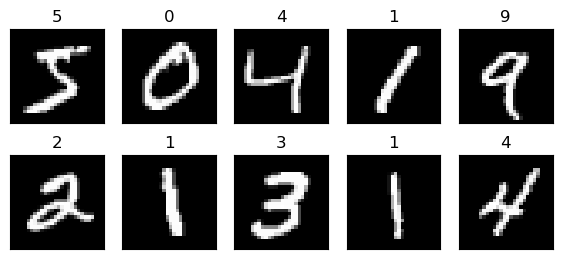

In [10]:
X = np.array(X)
fig, axes = plt.subplots(2, 5, figsize=(7, 3), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i, :].reshape(28,28), cmap=plt.cm.gist_gray)
    ax.set_title(y[i])
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    import matplotlib
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

P0każmy przykładem binarnego klasyfikatora, zdolnego rozróżnić tylko dwie klasy:
 * 5 
  nie-5. 
  
Stwórzmy docelowe zboty (trin/test) dla tego zadania klasyfikacji:

In [ ]:
# X_train = mnist.train.images 
# y_train = mnist.train.labels
# X_test = mnist.test.images
# y_test = mnist.test.labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
print(X_train.shape)
print(y_train_5.shape)
print(np.unique(y_train_5))

# Zad. 

Stwórzmy **LogisticRegression** i naucz go na całym zbiorze treningowym.


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train_5)

Teraz możesz go użyć aby wykryć czy dana liczba to  5:

In [ ]:
clf.predict([some_digit])

Klasyfikator poprawnie wskazał, że ten obraz reprezentuje 5 (prawda). 
Wygląda na to, że odgadł w tym konkretnym przypadku! 

## Teraz oceńmy wydajność tego modelu.

Wykorzystajmy funkcję 
```python
cross_val_score() 
```
do oceny naszego modelu **LogisticRegression** przy użyciu **K-fold crossvalidation**, z trzema fałdami. 

Pamiętaj, że **K-fold crossvalidation** oznacza podział zestawu treningowego na **K** części (w tym przypadku trzy), a następnie prognozowanie i ocenianie ich na każdym z kawałków przy użyciu modelu nauczonego na pozostałych danych (dwa pozostałe kawąłki).

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train_5, cv=3, scoring="accuracy")

**Łał! Powyżej 97% dokładności (stosunek prawidłowych przewidywań) na wszystkich zbiorach walidacyjnych!**

**To wygląda niesamowicie, prawda? **

Zanim wpadniemy w samozachwyt :), spójrzmy na bardzo głupi klasyfikator, który klasyfikuje każdy pojedynczy obraz do klasy "nie-5":

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return ??

# Zad.

Zgadnij jakie **accuracy** dostaniemy.

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

**Otrzymaliśmy ponad 90% dokładność! **

Wynika to z faktu, że tylko około 10% obrazów to 5., więc jeśli zawsze zgadniesz, że obraz to nie 5, będziesz mieć rację w około 90% przypadków. 

To pokazuje dlaczego **accuracy** nie jest na ogół preferowaną miarą wydajności klasyfikatorów, szczególnie gdy mamy do czynienia z niezbalansowanymi danymi (to znaczy, gdy niektóre klasy są znacznie częstsze niż inne).

# Confusion Matrix

 * Aby obliczyć **Confusion Matrix**, najpierw trzeba mieć zestaw prognoz, aby można je było porównać z rzeczywistymi etykietami.

 * Możesz przewidywać na zestawie testowym (test set), ale na razie trzymaj go nietknięty (pamiętaj, że chcesz użyć zestawu testowego tylko na samym końcu projektu, gdy masz klasyfikator, który jesteś gotowy do uruchomienia). 
 * Zamiast tego możesz użyć funkcji 
 ```pyrthon
 cross_val_predict()
 ```
 
 * Podobnie jak funkcja **cross_val_score()** funkcja **cross_val_predict()** wykonuje **K-fold cross-validation**, ale zamiast zwracać wyniki oceny, zwraca predykcje wykonane dla każdego testu. 

 * Oznacza to, że uzyskujesz czystą prognozę dla każdej instancji w zbiorze treningowym ("czysta" oznacza, że przewidywanie jest dokonywane przez model, który nigdy nie widział danych podczas treningu). 

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=3)
y_train_pred

# Confusion matrix
Do **confusion_matrix()** wystarczy przekazać etykiety docelowe (y_train_5) i przewidywane klasy (y_train_pred):

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

* Każdy rząd **confusion_matrix** reprezentuje rzeczywistą klasę, podczas gdy każda kolumna reprezentuje przewidywaną klasę.
* Pierwszy rząd tej macierzy uwzględnia obrazy inne niż 5 (klasa negatywna): 
  * 53 272 z nich zostało poprawnie sklasyfikowanych jako non-5 (**true negatives**), 
  *  1 307 zostało błędnie sklasyfikowane jako 5s (**false positives**). 
* Drugi rząd uwzględnia obrazy 5s (klasa pozytywna): 
  * 1 077 zostały błędnie sklasyfikowane jako nie-5 (**false negatives**), 
  * 4 344 zostały poprawnie sklasyfikowane jako 5s (**true positives**). 

Idealny klasyfikator miałby tylko **true positives** i **true negatives**, więc jego **confusion_matrix** miałaby niezerowe wartości tylko na swojej głównej przekątnej (od lewej górnej do prawej dolnej):

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

**Confusion matrix** dostarcza wielu informacji, ale bardziej przydatne sa miary numeryczne. 

 * **precision** to dokładność pozytywnych przewidywań -- precyzja klasyfikatora:

$$
precision = \frac{TP}{TP + FP}
$$
 
 * Prostym sposobem na uzyskanie doskonałej precyzji jest wykonanie jednej pozytywnej prognozy i zapewnienie jej poprawności (precision = 1/1 = 100%). 
 * Nie byłoby to zbyt użyteczne, ponieważ klasyfikator zignorowałby wszystkie oprócz jednego pozytywnego wystąpienia. 
 * Precyzję zwykle stosuje się wraz z inną miarą o nazwie **recall**, zwaną również czułością **sensitivity**.
 * **recall** jest to stosunek pozytywnych instancji, które są poprawnie wykrywane przez klasyfikator 
 
$$
recall = \frac{TP}{TP + FN}
$$

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) 
print(recall_score(y_train_5, y_train_pred)) 

### Teraz widzimy, że detektor piątek nie wygląda tak dobrze. 

* Kiedy twierdzi, że obraz reprezentuje 5, jest to poprawne tylko w 79% przypadków. 
* Co więcej, wykrywa tylko 81% z 5s.

# F1 score


 * Często wygodnie jest łączyć **precision** i **recall** w pojedynczą metrykę zwaną **F1 score** w szczególności jeśli potrzebujesz prostego sposobu na porównanie dwóch klasyfikatorów. 

 * Wynik **F1  score** jest średnią harmoniczną  **precision** i **recall**. 
 
$$
F_1 = \frac{2}{ \frac{1}{precision} + \frac{1}{recall} } = 2\frac{precision * recall}{precision + recall}
= \frac{TP}{TP + \frac{FN+FP}{2}}
$$

 * Podczas gdy klasyczna środek traktuje wszystkie wartości w równym stopniu **średnia harmoniczna** nadaje znacznie większą wagę mniejszym wartością. 

 * W rezultacie klasyfikator uzyska wysoki wynik **F1 score** jeśli zarówno  **precision** i **recall** będą wysokie.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, y_train_pred))#, target_names=["not 5", "5"]))

# Zad.

Wykonaj powyższą procedurę dziląc zbiór danych na train/test.

Wyznacz:

* precision
* recall
* f1-score
